In [1]:
import io
import ijson
import string

import pandas as pd
import numpy as np

import datetime
from datetime import datetime

import re

import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import *
from nltk.probability import FreqDist

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from mord import LogisticAT
import glmnet_python
from cvglmnet import cvglmnet
from glmnet import glmnet

from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

In [5]:
cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]

reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

a = datetime.datetime.now()

with open('reviews_electronics.6.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

        
b = datetime.datetime.now()
       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

review = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)
c=b-a
print(c.seconds)

__1.Treat each review as a document. Ignore misspellings. Convert all reviews to lower case. Remove stop words (use package to do this).__

In [5]:
def lowercase_remove_stopwords(text):
    '''
    Remove stop words
    '''
    text = text.replace('can\'t', 'can not')
    text = text.replace('n\'t', ' not')
    text_without_stopwords = [word for word in re.split(r'\W+', text.lower()) if word not in stopwords_without_neg]
    return ' '.join(text_without_stopwords).strip()

In [6]:
stop_words = stopwords.words('english')
stopwords_without_neg = [word for word in stop_words if ('n\'t' not in word) and ('not' not in word)]
review_copy = review.copy()
review_copy['reviewText'] = review_copy['reviewText'].progress_apply(lowercase_remove_stopwords)

__2. Handle negation: Look for the following two negations: "not" and "xxxn't" (e.g., don't, didn't etc.). Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword" (code this yourself).__

In [ ]:
def handle_negation(text):
    '''
    Convert xxxn't to 'xxx' and 'not'
    '''
    r = re.compile(r'(not) ([\S]+)')
    if r.findall(text) != []:
        text = r.sub(r'\1_\2', text)
    return text

In [ ]:
review_copy['reviewText'] = review_copy['reviewText'].progress_apply(handle_negation)

__3. Stem all words using Porter 1979 (use package to do this).__

In [ ]:
stemmer = PorterStemmer()
def stemming(text):
    '''
    Stem all words by Porter
    '''
    plurals = text.split()
    singles = [stemmer.stem(plural) for plural in plurals]
    return ' '.join(singles)

In [7]:
review_copy['reviewText'] = review_copy['reviewText'].progress_apply(stemming)

In [ ]:
review_copy['reviewText']

__4. Create frequency count table for all word stems in all reviews (this will be big). Use the most frequent 500 words to define the word vector. Create a bag-of-word vector representation for each review in electronics__

In [99]:
def top500(wordfreq):
    '''
    Find the most frequent 500 words
    '''
    aux = [(wordfreq[key], key) for key in wordfreq]
    aux.sort(reverse = True)
    words = [word for count, word in aux[:500]]
    return words

In [100]:
review_words = ' '.join(review_copy.reviewText.values.tolist())
word_df = pd.DataFrame(review_words.split(), columns = ['Words'])
wordfreq = dict(word_df['Words'].value_counts())
freq_words = top500(wordfreq)

In [101]:
def BoW(text):
    '''
    Create Bag of Words for each review
    '''
    vector = [] 
    for word in freq_words: 
        if word in text.split(): 
            vector.append(1) 
        else: 
            vector.append(0) 
    return vector

In [8]:
review_copy['BoW'] = review_copy['reviewText'].progress_apply(BoW)

__5. Establish a method for measuring the distance between different reviews. Print the mutual distance between the first 100 reviews (review IDs) to screen, sorted from
closest to furthest.__

In [103]:
hundred_reviews = review_copy.iloc[:100]['BoW']
bow = pd.DataFrame(index = review_copy.iloc[:100]['reviewerID'], columns = freq_words)
for i in range(100):
    bow.iloc[i] = hundred_reviews[i]
bow.head()

,use,work,one,great,would,good,get,like,product,time,...,smaller,own,total,direct,paid,older,con,ad,broke,onlin
reviewerID,,,,,,,,,,,,,,,,,,,,,
AKM1MP6P0OYPR,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A3F61V9Q3BF9TB,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
AT9KVPURE1V5,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A3LJN4DO57R82C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACQD60U39I587,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
def calculate_distance(review1, review2):
    '''
    Calculate the distance between reviews
    '''
    distance = (sum(abs(np.array(review1) - np.array(review2)))) ** 0.5
    return round(distance, 2)

In [106]:
dist_dict = {}
for i in range(len(bow)):
    for j in range(i + 1, len(bow)):
        review_id = (i, j)
        dist_dict[review_id] = calculate_distance(bow.iloc[i], bow.iloc[j])

In [107]:
dist_list = [(dist_dict[key], key) for key in dist_dict]
dist_list.sort()

__6. Run a PCA and graph the first two PCs for the first 100 reviews. Does your graph reflect your findings from the previous exercise?__

In [108]:
pca = PCA(n_components=2)
pca.fit(bow)
bow_transformed = pd.DataFrame(pca.transform(bow), columns = ['z1', 'z2'])
bow_transformed.head()

,z1,z2
0,-1.635674,-0.003877
1,-0.285473,-0.704454
2,-0.419137,-0.778506
3,-1.355450,-0.055217
4,-0.609331,0.040246


(-2.2078340826104443,
 7.219720833108498,
 -4.105178142746767,
 4.8117362135017885)

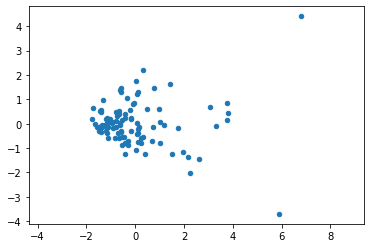

In [109]:
X = np.array(bow_transformed)
plt.scatter(X[:, 0], X[:, 1], s = 20)
plt.axis('equal')

In [110]:
def calculate_tran_dist(review1, review2):
    '''
    Calculate Eucolidean distance between two reviews
    '''
    dist = ((review1['z1'] - review2['z1']) ** 2 + (review1['z1'] - review2['z1']) ** 2) ** 0.5
#     dist = abs((review1['z1'] - review2['z1'] + review1['z2'] - review2['z2']))
    return round(dist, 5)

In [111]:
dist_dict_t = {}
for i in range(len(bow_transformed)):
    for j in range(i + 1, len(bow_transformed)):
        review_id = (i, j)
        dist_dict_t[review_id] = calculate_tran_dist(bow_transformed.iloc[i], bow_transformed.iloc[j])

In [112]:
dist_list_t = [(dist_dict_t[key], key) for key in dist_dict_t]
dist_list_t.sort()

The distances of top 5 closest reviews based on BoW calculated by PCA

In [113]:
top5 = [idx for dist, idx in dist_list[:5]]
[(dist_dict_t[review], review) for review in top5]

[(0.09419, (3, 34)),
 (0.6059, (11, 16)),
 (0.18992, (16, 84)),
 (0.2158, (16, 34)),
 (0.15286, (16, 61))]

__7. Is it possible to use logistic regression to predict the rating (5 levels) of a
product? Why may it be advantageous to use a logistic regression to predict the 5-star rating over MNL with 5 categories?__

MNL will lose the information of a rating of 5 superior to that of 4.
Instead of passing a binary variable to the logistic regression, we transfer the rating from 1 to 5 to 0.25 to 1, making it a non-standard logistic regression. And the cutoff point for each level is 0.2 to 1, respectively.

__8. Perform a lasso logistic regression and measure the out-of-sample accuracy of your method of choice.__

In [212]:
def top10(wordfreq):
    '''
    Find the most frequent 10 words
    '''
    aux = [(wordfreq[key], key) for key in wordfreq if key not in freq_words]
    aux.sort(reverse = True)
    words = [word for count, word in aux[:10]]
    return words

In [115]:
def BoW_summary(text):
    '''
    Create Bag of Words for summary
    '''
    vector = [] 
    for word in freq_words_summary: 
        if word in text.split(): 
            vector.append(1) 
        else: 
            vector.append(0) 
    return vector

In [9]:
review_copy['summary'] = review_copy['summary'].progress_apply(lowercase_remove_stopwords)
review_copy['summary'] = review_copy['summary'].progress_apply(handle_negation)
review_copy['summary'] = review_copy['summary'].progress_apply(stemming)

In [10]:
summary_fdist = pd.DataFrame(summary.split(), columns = ['Words'])
wordfreq = dict(summary_fdist['Words'].value_counts())
freq_words_summary = top10(wordfreq)

summary_bow = review_copy['summary'].progress_apply(BoW_summary)
bow_for_summary = pd.DataFrame(np.asarray([bow for bow in summary_bow]), columns = freq_words_summary)

In [217]:
bow_for_all = pd.DataFrame(np.asarray([bow for bow in review_copy['BoW']]), columns = freq_words)
df = pd.concat([review_copy, bow_for_all, bow_for_summary], axis=1)

col = list(df.columns[3:5]) + [df.columns[8]] + list(df.columns[11:])
X = df[col]
y = df['overall'].apply(lambda x: int(x))

sc_X = StandardScaler()
X_transformed = pd.DataFrame(sc_X.fit_transform(X))
X_transformed.columns = X.columns.values

In [221]:
def acc_fun(target_true, target_fit):
    target_fit = np.round(target_fit)
    target_fit.astype('int')
    return accuracy_score(target_true, target_fit)

In [222]:
model_ordinal = LogisticAT(alpha=1)
acc = make_scorer(acc_fun)
folds = 3

acc_ordinal = cross_val_score(model_ordinal, X_transformed, y, cv=folds, scoring=acc)
print('Ordered logistic regression: ', np.mean(acc_ordinal))

Ordered logistic regression:  0.5487918849290961
